In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# hyperparameters
batch_size = 32  # how many independent sequences will we train on in parallel?
context_length = 8  # what is the maxiumum context length (characters) for predictions?
num_embeddings = 32  # what is the number of embeddings for each token in our vocabulary?
max_iterations = 3000  # how many training iterations to run in total?
eval_interval = 300  # how many iterations to run between evaluations?
learning_rate = 1e-2  # how quickly do we descend the gradient?
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # what device do we use to train?
eval_iters = 200

torch.manual_seed(1337)

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-12-17 20:28:05--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.9’

input.txt.9         100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2023-12-17 20:28:06 (10.3 MB/s) - ‘input.txt.9’ saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(text[:1000])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
characters = sorted(list(set(''.join(text)))) 
print(characters)
print(len(characters))
token_mappings = {c:i for i,c in enumerate(characters)}
index_to_character = {i:c for i,c in enumerate(characters)}
print(token_mappings)
print(index_to_character)

def encode(text: str) -> list[int]:
    return [token_mappings[c] for c in text]

def decode(tokens: list[int]) -> str:
    return ''.join([index_to_character[t] for t in tokens])

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11

In [6]:
print(encode('hii there'))
print(decode(encode('hii there')))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape)
print(data[:100])

torch.Size([1115394])
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [8]:
n = int (len(data) * 0.9)
train_data = data[:n]
val_data = data[n:]

In [9]:
x = train_data[:context_length]
y = train_data[1:context_length+1]
for t in range(context_length):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
context_length = 8 # what is the maximum context length for predictions?

print(f"This will generate {batch_size * context_length} samples per batch")

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # grab e.g. 4 random starting indices
    ix = torch.randint(len(data) - context_length, (batch_size,))
    # construct the inputs and targets for each of the 4 sequences
    # for each sequence, we grab the next 8 characters as the input
    # and the 8 characters after that as the target
    # which is why we need to subtrack the context length from the length above
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(context_length): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

This will generate 32 samples per batch
inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 

- self-attention explanation: https://youtu.be/kCc8FmEb1nY?si=-egoRzeqjbKo3jlf&t=3839

In [11]:
class Head(nn.Module):
    """One head of self-attention."""

    def __init__(self, head_size: int, num_embeddings: int):
        super().__init__()
        self.key = nn.Linear(num_embeddings, head_size, bias=False)
        self.query = nn.Linear(num_embeddings, head_size, bias=False)
        self.value = nn.Linear(num_embeddings, head_size, bias=False)
        # a buffer is a tensor that is not a model parameter
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))
    
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        # compute attention scores (i.e. 'affinities')
        wei = q @ k.transpose(-2, -1)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out


class MultiheadAttention(nn.Module):
    """Multiple heads of self-attention in parallel."""

    def __init__(self, num_heads: int, head_size: int, num_embeddings: int):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, num_embeddings) for _ in range(num_heads)])

    def forward(self, x):
        # each head returns a tensor of shape (B, T, head_size)
        # we concatenate them all together and then apply a linear layer
        # to map the concatenated tensor to the original dimension
        return torch.cat([head(x) for head in self.heads], dim=-1)  # (B, T, num_heads * head_size)


class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size: int, context_length: int, num_embeddings: int):
        super().__init__()
        self.context_length = context_length
        self.token_embedding_table = nn.Embedding(vocab_size, num_embeddings)
        self.position_embedding_table = nn.Embedding(context_length, num_embeddings)
        # self.self_attention_head = Head(head_size=num_embeddings, num_embeddings=num_embeddings)
        self.self_attention_heads = MultiheadAttention(
            num_heads=4,
            head_size=num_embeddings // 4,
            num_embeddings=num_embeddings,
        )
        self._linear_head = nn.Linear(num_embeddings, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B, T) tensor of integers
        # B= batch, T = time (context length), C = channel (num_embeddings)
        # e.g. if batch size is 4 and context length is 8, and num_embeddings is 56
        # then logit.shape = (4, 8, 56)
        token_embeddings = self.token_embedding_table(idx)  # (B, T, C) i.e. (B, T, num_embeddings)
        position_embeddings = self.position_embedding_table(torch.arange(T, device=device))
        x = token_embeddings + position_embeddings  # (B, T, C)
        x = self.self_attention_heads(x)  # apply one head of self-attention
        logits = self._linear_head(x)  # (B, T, vocab_size)
        if targets is None:
            return logits, None

        # pytorch cross entropy expects (B, C, T) as input rather than (B, T, C)
        B, T, C = logits.shape
        # e.g. if batch size is 4 and context length is 8, and vocab size is 56
        # then logits.view(B*T, C) will be (32, 56)
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idf is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # if the context is longer than the context length, then we only
            # consider the last context_length tokens
            index_cond = idx[:, -self.context_length:]
            logits, _ = self(index_cond)
            # focus only on the last time step (i.e. the last token/character)
            logits = logits[:, -1, :]  # becomes (B, C)
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append to the context
            idx = torch.cat([idx, idx_next], dim=1)  # (B, T+1)
        return idx
    

m = BigramLanguageModel(len(characters), context_length=context_length, num_embeddings=num_embeddings)
m = m.to(device)
print(f"Model parameters: {sum([p.numel() for p in m.parameters()])}")
print(xb.shape)
out, loss = m(xb, yb)
print(out)
print(out.shape)
print(loss)
print((batch_size, context_length, len(characters)))

Model parameters: 7553
torch.Size([4, 8])
tensor([[ 0.2163, -0.1186, -0.2929,  ..., -0.4157,  0.8209,  0.2440],
        [ 0.3689,  0.0342, -0.3620,  ...,  0.1816,  0.7653,  0.2024],
        [-0.0626,  0.6402, -0.2719,  ...,  0.1306,  0.2134, -0.1146],
        ...,
        [ 0.3244, -0.3352, -0.0098,  ..., -0.0441,  0.6653, -0.1905],
        [-0.4548,  0.0529,  0.0245,  ..., -0.2095,  0.3074, -0.2397],
        [-0.9060,  0.0564, -0.0106,  ..., -0.3297,  0.6187, -0.3686]],
       grad_fn=<ViewBackward0>)
torch.Size([32, 65])
tensor(4.2648, grad_fn=<NllLossBackward0>)
(4, 8, 65)


In [12]:
_x = torch.zeros((1, 1), dtype=torch.long)
print(_x)
print(decode(m.generate(_x, max_new_tokens=100)[0].tolist()))


tensor([[0]])

ccOlyVJDq:X&edpv,b? rPDuCslAS-noNch-Nryw:$jupUj
 T'.G&GuEm !p:aljK.$u. rCpIadhkIXtRBEtnxE:cTmFXNOPN&


In [13]:
@torch.no_grad()
def estimate_loss():
    m.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            x, y = get_batch(split)
            _, loss = m(x, y)
            losses[i] = loss.item()
        out[split] = losses.mean().item()
    m.train()
    return out

In [14]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

In [15]:
batch_size = 32
steps = 10000
for index in range(steps): # increase number of steps for good results... 
    # sample a batch of data
    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # keep track of the loss
    if index % (steps / 20) == 0 or index == steps - 1:
        average_loss = estimate_loss()
        losses.append(average_loss)
        print(f"({index}) Training Loss (average): {average_loss['train']:.3f}, Validation Loss (average): {average_loss['train']:.3f}")

Training Loss (average): 4.190, Validation Loss (average): 4.190
Training Loss (average): 2.671, Validation Loss (average): 2.671
Training Loss (average): 2.506, Validation Loss (average): 2.506
Training Loss (average): 2.412, Validation Loss (average): 2.412
Training Loss (average): 2.367, Validation Loss (average): 2.367
Training Loss (average): 2.340, Validation Loss (average): 2.340


KeyboardInterrupt: 

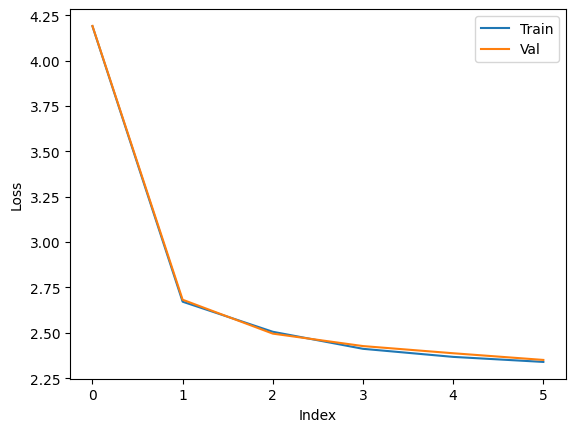

In [16]:
import matplotlib.pyplot as plt

# Assuming `losses` is the list of dictionaries
train_losses = [d['train'] for d in losses]
val_losses = [d['val'] for d in losses]
indices = range(len(losses))

plt.plot(indices, train_losses, label='Train')
plt.plot(indices, val_losses, label='Val')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.legend()
plt.show()


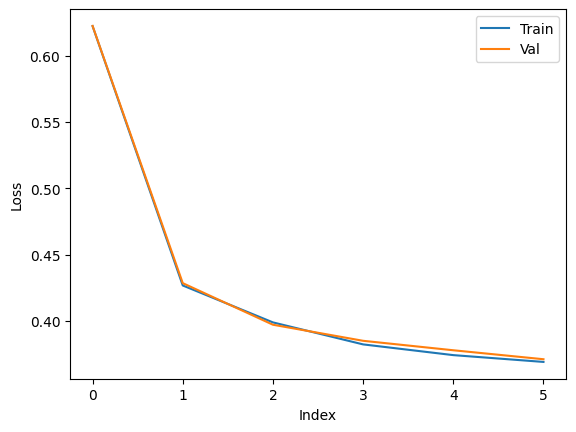

In [17]:
import matplotlib.pyplot as plt
import math

# Assuming `losses` is the list of dictionaries
train_losses = [math.log10(d['train']) for d in losses]
val_losses = [math.log10(d['val']) for d in losses]
indices = range(len(losses))

plt.plot(indices, train_losses, label='Train')
plt.plot(indices, val_losses, label='Val')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(context)
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))


tensor([[0]])

Yo in
YITCl fis yorkbune luyou yowsthe;
Mavave apilllotld.

VODUW
ATUE I mo py che to sprty may aple


---

# Appendix

## Self-Attention mathmatical trick

- we have 8 tokens in our context that are not talking to each other, and we would like them to
- but we want to do it in a specific way e.g. token 5 should not communicate with tokens 6, 7, 8, because those tokens are in the future and token 5 doesn't know about them. But token 5 should talk to the previous tokens
- the simplest way to do this is an average of all of the proceeding tokens; this would give the context of the previous characters 
- but we would also lose a lot of information if we just did a simple average, we would have lost the spacial (temporal?) information of all those tokens
- but that's ok for now, we will see how we can bring the information back later

In [ ]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2  # batch size, context length (time), vocab size (channel)
x = torch.randn(B, T, C)
print(x.shape)
print(x)

In [ ]:
# this is very inefficient, but it's easy to understand
x_bag_of_words = torch.zeros(B, T, C)
x_bag_of_words.shape
for b in range(B):
    for t in range(T):
        x_previous = x[b, :t+1]  # (t, C)
        # average over the time dimension (dim=0) to get a single vector of size (C,)
        # i think this is the average of the embeddings of the previous (and current) tokens
        x_bag_of_words[b, t] = torch.mean(x_previous, dim=0)  # (C,)

x_bag_of_words

# https://youtu.be/kCc8FmEb1nY?si=nt0pZ4a7IGkQSl_E&t=2825



In [ ]:
# because of dot product we are basically doing a running average
a = torch.tril(torch.ones(3, 3))
print(a)
a = a / torch.sum(a, 1, keepdim=True)
print(a)
# now if we multiple by another matrix, we will get average
# because of the dot product
# instead of dividing by e.g. 1, 2, 3 we are multiplying by 1/1, 1/2, 1/3
# which is the same thing

In [ ]:
_weights = torch.tril(torch.ones(T, T))
print(_weights)
_weights = _weights / torch.sum(_weights, 1, keepdim=True)
print(_weights)
x_bag_of_words_2 = _weights @ x
assert torch.allclose(x_bag_of_words, x_bag_of_words_2)
print(x_bag_of_words_2)

In [ ]:
# version 3
# https://youtu.be/kCc8FmEb1nY?si=bVuXGcd8V5ky71xL&t=3277

tril = torch.tril(torch.ones(T, T))
_weights = torch.zeros(T, T)
_weights = _weights.masked_fill(tril == 0, float('-inf'))
_weights = F.softmax(_weights, dim=1)
x_bag_of_words_3 = _weights @ x
assert torch.allclose(x_bag_of_words, x_bag_of_words_3)

---